In [1]:
from libs.data_manipulation import *
from libs.dim_reduction import *
from libs.feature_generation import *
from libs.clustering import *
from libs.convex_hull import *

from mplsoccer import Pitch
import os
import matplotlib.pyplot as plt
from mplsoccer import Pitch
from scipy.spatial import ConvexHull
from matplotlib.patches import Polygon
import alphashape


In [2]:
df = compile_team_tracking_data("data/H_EURO2024GERMANY", "Denmark")
df = extract_one_match(df,1)


In [3]:
import alphashape
from shapely.geometry import Polygon

def alpha_shape(df: pd.DataFrame, regex: str = "^home", num_players: int = None, alpha: float = 0.1):
    """
    Computes alpha shapes for player positions, allowing the selection of a subset of players.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing player positions.
    regex (str): A regex pattern to filter player positions in the DataFrame.
    num_players (int): The number of players to include in the alpha shape (optional).
    alpha (float): The alpha value for the alpha shape algorithm.
    
    Returns:
    list: A list of alpha shape polygons for each frame of data.
    """
    # Filter columns based on the regex
    df = df.filter(regex=regex)
    np_data = df.to_numpy()  # Convert the DataFrame to a NumPy array
    points = []

    # Process each frame of data to extract player positions
    for row in np_data:
        row = row[~np.isnan(row)]  # Remove NaN values (incomplete player positions)
        player_positions = list(zip(row[0::2], row[1::2]))  # Create (x, y) pairs

        # If num_players is specified, limit the number of players
        if num_players is not None and len(player_positions) > num_players:
            # Sort players by their distance to the center of the field (or other criteria)
            center = np.mean(player_positions, axis=0)  # Calculate the central point (e.g., mean position)
            player_positions = sorted(player_positions, key=lambda pos: np.linalg.norm(np.array(pos) - center))
            player_positions = player_positions[:num_players]  # Select the top N closest players

        points.append(player_positions)

    # Compute alpha shapes for each frame
    alpha_shapes = []
    for data in points:
        if len(data) >= 3:  # Alpha shape requires at least 3 points
            # Compute alpha shape for the points
            alpha_shape_polygon = alphashape.alphashape(data, alpha)
            alpha_shapes.append(alpha_shape_polygon)

    return alpha_shapes, df.index.to_numpy()




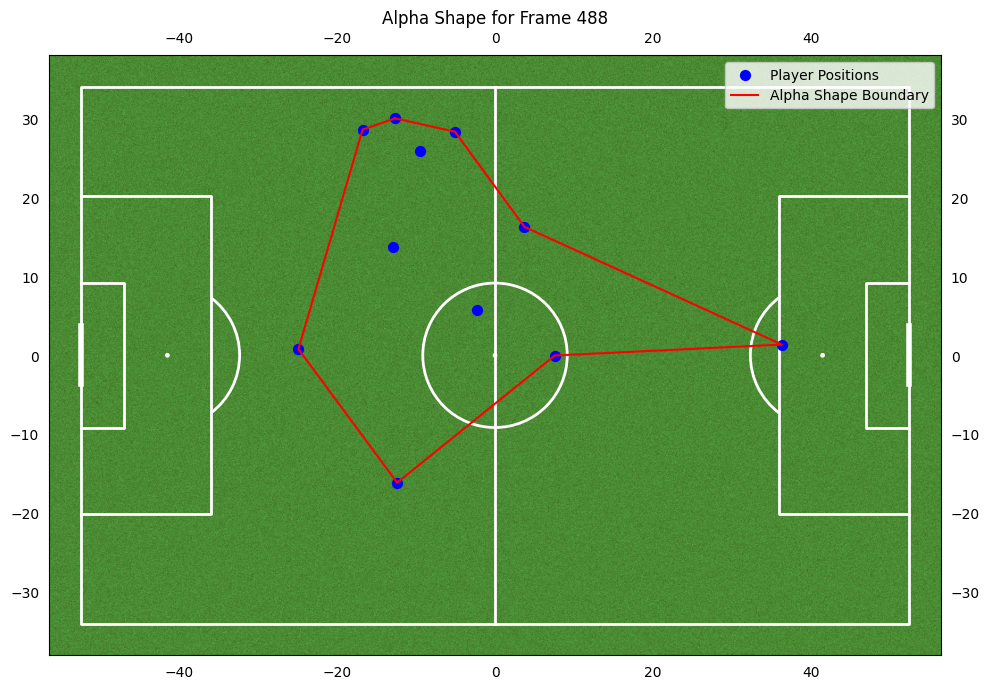

In [4]:

# Now run the alpha shape function with a smaller alpha value
alpha_shapes, frame_indices = alpha_shape(df.iloc[::48], "^home", num_players=11, alpha=0.05)

# Plot the alpha shape for a specific frame
frame_idx = 488

# Create a plot with the pitch
football_pitch = Pitch(pitch_type='skillcorner', pitch_length=105, pitch_width=68, axis=True, label=True, line_color="white", pitch_color="grass")
fig, ax = football_pitch.draw(figsize=(10, 7))

# Scatter the player points for that frame
players = df.iloc[frame_indices[frame_idx]].filter(regex="^home").dropna().values.reshape(-1, 2)
ax.scatter(players[:, 0], players[:, 1], color='blue', s=50, label="Player Positions")

# Plot the alpha shape if it's a Polygon
alpha_shape_polygon = alpha_shapes[frame_idx]
if isinstance(alpha_shape_polygon, Polygon):
    x, y = alpha_shape_polygon.exterior.xy
    ax.plot(x, y, color='red', label="Alpha Shape Boundary")

plt.legend()
plt.title(f"Alpha Shape for Frame {frame_idx}")
plt.show()

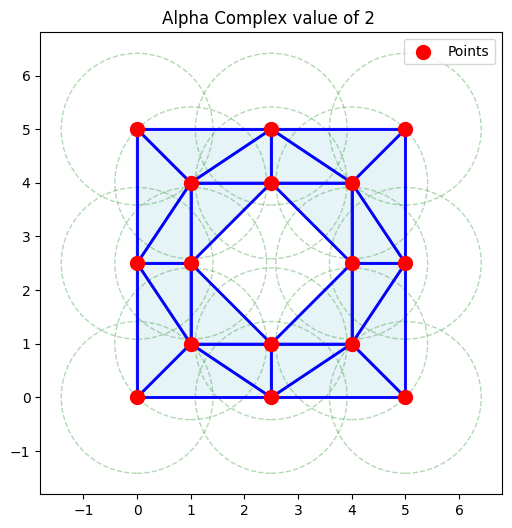

In [87]:
import numpy as np
import gudhi as gd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Sample points: outer square and inner square (with more points on the edges)
outer_square_points = np.array([
    [0, 0], [0, 5], [5, 5], [5, 0],  # Corners of the outer square
    [2.5, 5], [0, 2.5], [5, 2.5], [2.5, 0]  # Midpoints of the outer square edges
])

inner_square_points = np.array([
    [1, 1], [1, 4], [4, 4], [4, 1],  # Corners of the inner square (hole)
    [2.5, 4], [1, 2.5], [4, 2.5], [2.5, 1]  # Midpoints of the inner square edges
])

# Combine points from the outer and inner squares
points = np.vstack((outer_square_points, inner_square_points))

# Increase alpha value by adjusting max_alpha_square
max_alpha_square = 2  # Squared alpha value
alpha_complex = gd.AlphaComplex(points=points)
simplex_tree = alpha_complex.create_simplex_tree(max_alpha_square=max_alpha_square)

# Plot alpha complex with filtration (alpha value)
plt.figure(figsize=(6, 6))
ax = plt.gca()

# Loop through simplices to plot edges (1D)
for simplex in simplex_tree.get_skeleton(1):  # 1D simplices (edges)
    if len(simplex[0]) == 2:  # Only plot edges
        vertices = [points[vertex] for vertex in simplex[0]]
        vertices = np.array(vertices)
        plt.plot(vertices[:, 0], vertices[:, 1], 'b-', lw=2)  # Plot the edges (lines)

# Loop through simplices and highlight triangles (2D)
for simplex in simplex_tree.get_skeleton(2):  # 2D simplices (triangles)
    if len(simplex[0]) == 3:  # We want only triangles (2D simplices)
        vertices = [points[vertex] for vertex in simplex[0]]
        vertices = np.array(vertices)
        polygon = patches.Polygon(vertices, closed=True, facecolor="lightblue", edgecolor="blue", lw=2, alpha=0.3)
        ax.add_patch(polygon)

# Plot the points and circles for each point
for point in points:
    circle = plt.Circle(point, np.sqrt(max_alpha_square), color='green', fill=False, linestyle='--', alpha = 0.3)  # Circle size based on alpha
    ax.add_patch(circle)

plt.scatter(points[:, 0], points[:, 1], color="red", s=100, zorder=3, label="Points")
plt.title("Alpha Complex value of {} ".format(max_alpha_square)) 
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
plt.show()


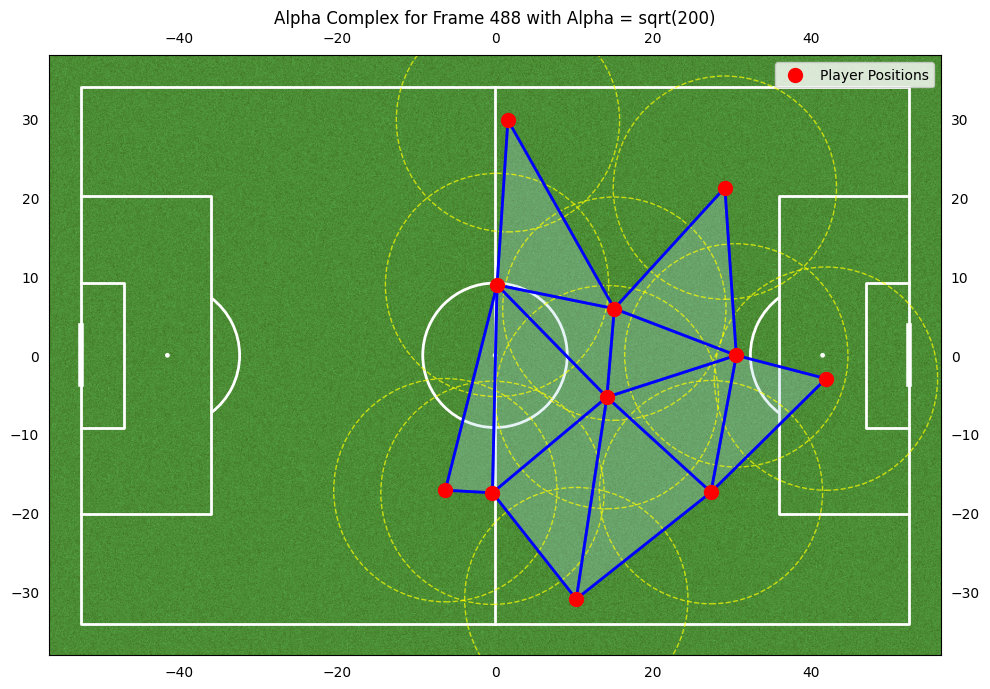

In [111]:
import numpy as np
import gudhi as gd
import matplotlib.pyplot as plt
from mplsoccer import Pitch
import pandas as pd
import matplotlib.patches as patches

# Define a function to extract player positions and apply alpha complex with circles
def alpha_complex_on_frame(df: pd.DataFrame, regex: str = "^home", frame_idx: int = 0, max_alpha_square=2):
    """
    Applies the Alpha Complex method on the player positions in a specific frame of data.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing player positions.
    regex (str): A regex pattern to filter player positions in the DataFrame.
    frame_idx (int): The specific frame (row) in the DataFrame to visualize.
    max_alpha_square (float): Maximum squared alpha value for the Alpha Complex.
    """
    # Filter columns based on the regex to get player positions
    players = df.iloc[frame_idx].filter(regex=regex).dropna().values.reshape(-1, 2)

    # Create Alpha Complex from points (player positions)
    alpha_complex = gd.AlphaComplex(points=players)
    simplex_tree = alpha_complex.create_simplex_tree(max_alpha_square=max_alpha_square)

    # Create a plot with the football pitch
    football_pitch = Pitch(pitch_type='skillcorner', pitch_length=105, pitch_width=68, axis=True, label=True, line_color="white", pitch_color="grass")
    fig, ax = football_pitch.draw(figsize=(10, 7))

    # Plot player points
    ax.scatter(players[:, 0], players[:, 1], color='red', s=100, zorder=3, label="Player Positions")

    # Loop through simplices to plot edges (1D)
    for simplex in simplex_tree.get_skeleton(1):  # 1D simplices (edges)
        if len(simplex[0]) == 2:  # Only plot edges
            vertices = [players[vertex] for vertex in simplex[0]]
            vertices = np.array(vertices)
            ax.plot(vertices[:, 0], vertices[:, 1], 'b-', lw=2)  # Plot the edges (lines)

    # Loop through simplices and highlight triangles (2D)
    for simplex in simplex_tree.get_skeleton(2):  # 2D simplices (triangles)
        if len(simplex[0]) == 3:  # We want only triangles (2D simplices)
            vertices = [players[vertex] for vertex in simplex[0]]
            vertices = np.array(vertices)
            polygon = patches.Polygon(vertices, closed=True, facecolor="lightblue", edgecolor="blue", lw=2, alpha=0.3)
            ax.add_patch(polygon)

    # Plot circles around each player, proportional to the square root of max_alpha_square
    for point in players:
        circle = plt.Circle(point, np.sqrt(max_alpha_square), color='yellow', fill=False, linestyle='--', alpha=0.7)
        ax.add_patch(circle)

    plt.legend()
    plt.title(f"Alpha Complex for Frame {frame_idx} with Alpha = sqrt({max_alpha_square})")
    plt.show()

frame_idx = 488  # Example frame index

# Apply alpha complex and plot for a specific frame with circles
alpha_complex_on_frame(df, regex="^home", frame_idx=frame_idx, max_alpha_square=200)
